In [1]:
import numpy as np
import scipy as sp
import os
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn import decomposition

In [2]:
data_path = os.path.join("..", "data", "output_2020-06-20T18-44-19.npy")
x = np.load(data_path, allow_pickle=True)

artefacts = np.array([a[5] for a in x])
agend_ids = np.array([a[1] for a in x])

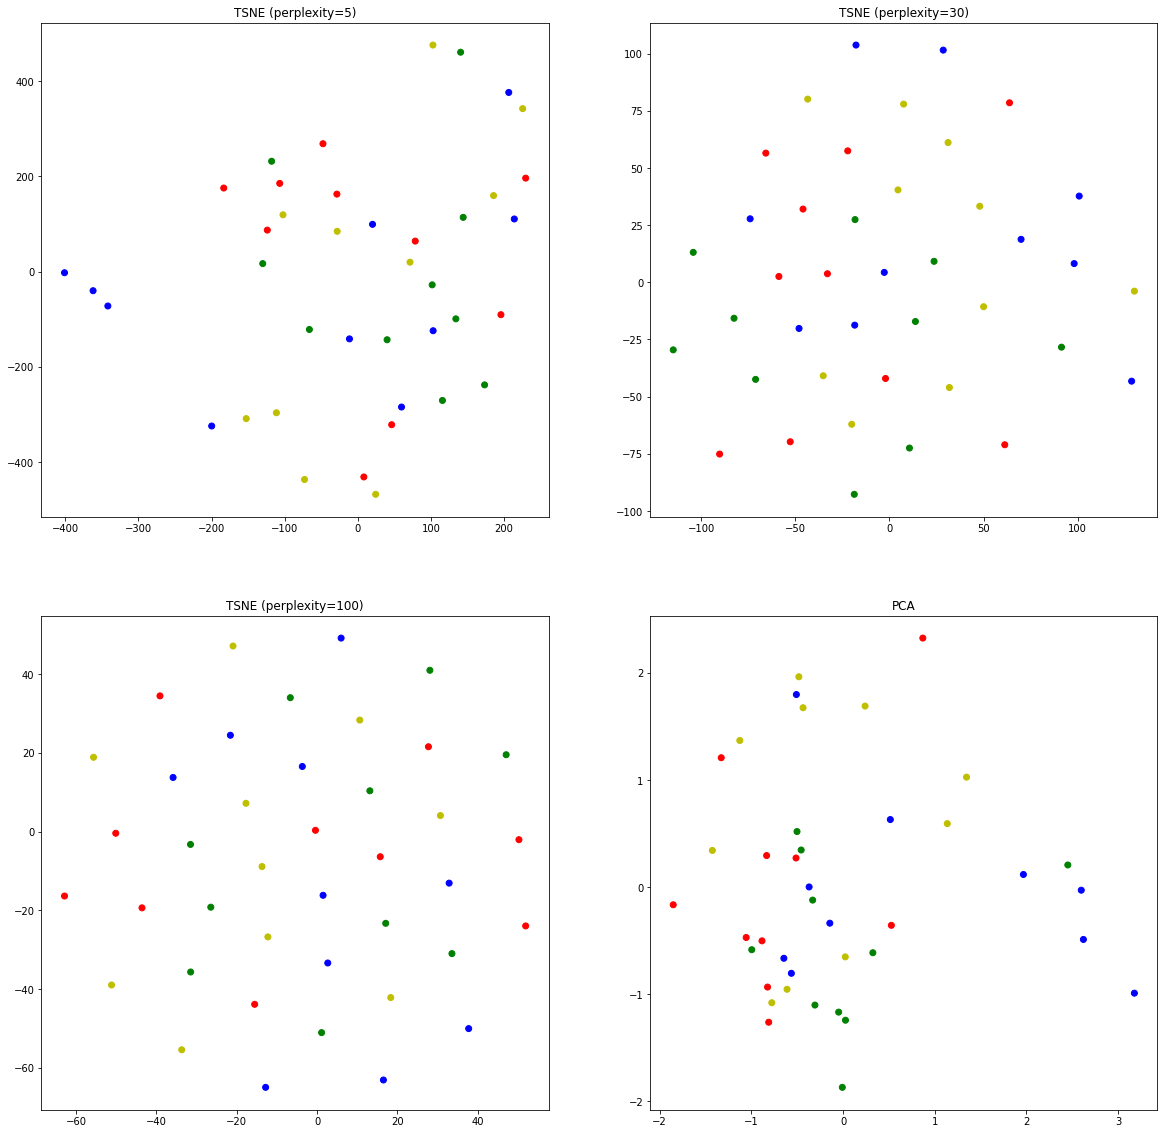

In [31]:
def get_color(agent_id):
    if agent_id == 0:
        return 'r'
    if agent_id == 1:
        return 'g'
    if agent_id == 2:
        return 'b'
    if agent_id == 3:
        return 'y'

fig, axs = plt.subplots(2, 2, figsize=(20, 20))

colors = [get_color(agent_id) for agent_id in agend_ids]
perplexities = [5, 30, 100]

for i, ax in enumerate(axs.flatten()):
    if i < 3:
        tsne = manifold.TSNE(n_components=2, perplexity=perplexities[i])
        embedded = tsne.fit_transform(artefacts)
        ax.set_title(f"TSNE (perplexity={perplexities[i]})")
    else:
        pca = decomposition.PCA(n_components=2)
        embedded = pca.fit_transform(artefacts)
        ax.set_title("PCA")
    
    ax.scatter(embedded[:, 0], embedded[:,1], c=colors)
    
plt.show()

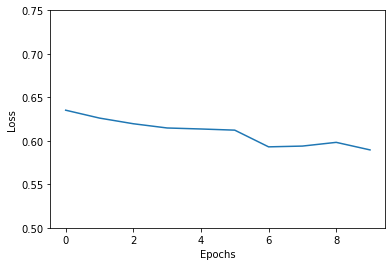

In [29]:
data_val_path = os.path.join("..", "data", "output_2020-06-20T18-44-19_validation.npy")
validations = np.load(data_val_path, allow_pickle=True)

plt.plot(range(len(validations)), validations)
plt.gca().set_ylabel('Loss')
plt.gca().set_xlabel('Epochs')
plt.gca().set_ylim(.5, .75)
plt.show()

In [7]:
%%time
hull = sp.spatial.ConvexHull(artefacts)

CPU times: user 32.2 s, sys: 845 ms, total: 33.1 s
Wall time: 33.3 s


In [18]:
volumes = []

for i in range(33, len(artefacts) + 1):
    points = np.array(artefacts[:i])
    hull = sp.spatial.ConvexHull(points)
    volumes.append(hull.volume)

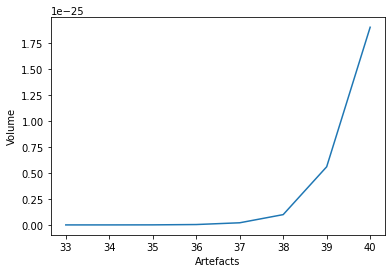

In [24]:
plt.plot(range(33, len(volumes) + 33), volumes)
plt.gca().set_ylabel('Volume')
plt.gca().set_xlabel('Artefacts')
plt.show()